In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

In [2]:
dataset = 'tabula-muris-heart'
data_path = "../dataset/{}-filtered/10X/".format(dataset)
labels_path = "../dataset/{}-filtered/labels.csv".format(dataset)
markers_path = "../results/aggregate/{}/markers.csv".format(dataset)
scores_path = "./scores/{}.pickle".format(dataset)

In [3]:
adata = sc.read_10x_mtx(
    data_path,
    var_names='gene_symbols',
    cache=False
)

In [4]:
y_df = pd.read_csv(labels_path, index_col=0)
y_df

,cluster.ids
cell,
AAACCTGCACGACGAA,4
AAACCTGGTTCCACGG,5
AAACCTGTCTCGATGA,4
AAACGGGAGCGCTCCA,1
AAAGCAAAGTGAATTG,5
...,...
TTTGGTTCAGACTCGC,2
TTTGTCAAGTGGAGAA,2
TTTGTCACAAGCCATT,3


In [5]:
y_df = pd.DataFrame(adata.obs_names, columns=["cell"]).join(y_df, on="cell")
y_df

,cell,cluster.ids
0,AAACCTGCACGACGAA,4
1,AAACCTGGTTCCACGG,5
2,AAACCTGTCTCGATGA,4
3,AAACGGGAGCGCTCCA,1
4,AAAGCAAAGTGAATTG,5
...,...,...
612,TTTGGTTCAGACTCGC,2
613,TTTGTCAAGTGGAGAA,2
614,TTTGTCACAAGCCATT,3
615,TTTGTCAGTCGATTGT,4


In [6]:
mask = ~np.isnan(np.array(y_df['cluster.ids'])).reshape(-1)
mask[mask==False]

array([], dtype=bool)

In [7]:
y_df['cluster.ids'][mask]

0      4
1      5
2      4
3      1
4      5
      ..
612    2
613    2
614    3
615    4
616    5
Name: cluster.ids, Length: 617, dtype: int64

In [8]:
y = np.array(y_df['cluster.ids'][mask])

In [9]:
clusters, counts = np.unique(y, return_counts=True)
clusters, counts

(array([1, 2, 3, 4, 5]), array([ 98,  60,  62, 172, 225]))

In [10]:
weights = counts[np.argsort(clusters)]

In [11]:
def apply_classifier(X, y):
    clf = RandomForestClassifier()
    y_pred = cross_val_predict(clf, X, y, cv=5)
    f1 = f1_score(y, y_pred)
    return f1

markers_df = pd.read_csv(markers_path)
tools = markers_df.tool.unique()

f1_markers = {}
for tool in tools:
    f1_markers_tool = []
    for cluster in clusters:
        y_bin = np.array(y==cluster, dtype=int)
        markers = markers_df[
            (markers_df['cluster']==cluster) & (markers_df['tool']==tool)
           ].gene.unique()
        X_markers = adata[mask, markers].X.toarray()
        f1_markers_tool.append(apply_classifier(X_markers, y_bin))
    f1_markers[tool] = round((weights*np.array(f1_markers_tool)).sum()/weights.sum(), 3)

f1_all = []
for cluster in clusters:
    y_bin = np.array(y==cluster, dtype=int)
    X_all = adata[mask, ].X.toarray()
    f1_all.append(apply_classifier(X_all, y_bin))
f1_weighted = round((weights*np.array(f1_all)).sum()/weights.sum(), 3)

print("F1 weighted when training on markers")
print(f1_markers)
print("F1 weighted when training on all genes")
print(f1_weighted)

F1 weighted when training on markers
{'monocle': 0.97, 'scanpy': 0.972, 'seurat': 0.973, 'scvi': 0.974}
F1 weighted when training on all genes
0.984


In [12]:
import sys
from joblib import Parallel, delayed
def process(tool):
    step = 1
    tmp_scores = {}
    for cluster in clusters:
        n_markers = 50
        y_bin = np.array(y==cluster, dtype=int)
        for i in range(step, n_markers+step, step):
            markers = markers_df[
            (markers_df['cluster']==cluster) & (markers_df['tool']==tool) & (markers_df['rank']<=i)].gene.unique()
            X = adata[mask, markers].X.toarray()
            f1 = apply_classifier(X, y_bin)
            if tool not in tmp_scores:
                tmp_scores[tool] = {}
            if cluster not in tmp_scores[tool]:
                tmp_scores[tool][cluster] = {}
            if 'scores' not in tmp_scores[tool][cluster]:
                tmp_scores[tool][cluster]['scores'] = []
            tmp_scores[tool][cluster]['scores'].append(f1)
        if 'mean' not in tmp_scores[tool][cluster]:
            tmp_scores[tool][cluster]['mean'] = []
        # mean for each cluster
        tmp_scores[tool][cluster]['mean'].append(np.mean(tmp_scores[tool][cluster]['scores']))
        print("Cluster {} done for tool {}".format(cluster, tool), file=sys.stderr)
        
    return tmp_scores

In [13]:
# -------- train with increasing # of features taken from markers rank --------
step = 1
tools = ['scvi', 'seurat', 'scanpy', 'monocle']
n_markers = 50
import pickle, os
if os.path.exists(scores_path):
    with open(scores_path, 'rb') as handle:
        scores = pickle.load(handle)
else:
    scores = Parallel(n_jobs=len(tools))(delayed(process)(tool) for tool in tools)
    scores2 = {}
    for i, el in enumerate(scores):
        scores2[list(el.keys())[0]] = el[list(el.keys())[0]]
    scores = scores2
    for tool in tools:
        for i in range(step, n_markers+step, step):
            sumForI = 0
            for j, cluster in enumerate(clusters):
                sumForI += (scores[tool][cluster]['scores'][i-1] * counts[j])
            if 'TotalMean' not in scores[tool]:
                scores[tool]['TotalMean'] = []
            scores[tool]['TotalMean'].append(sumForI/np.sum(counts))
    with open(scores_path, 'wb') as handle:
        pickle.dump(scores, handle, protocol=pickle.HIGHEST_PROTOCOL)   

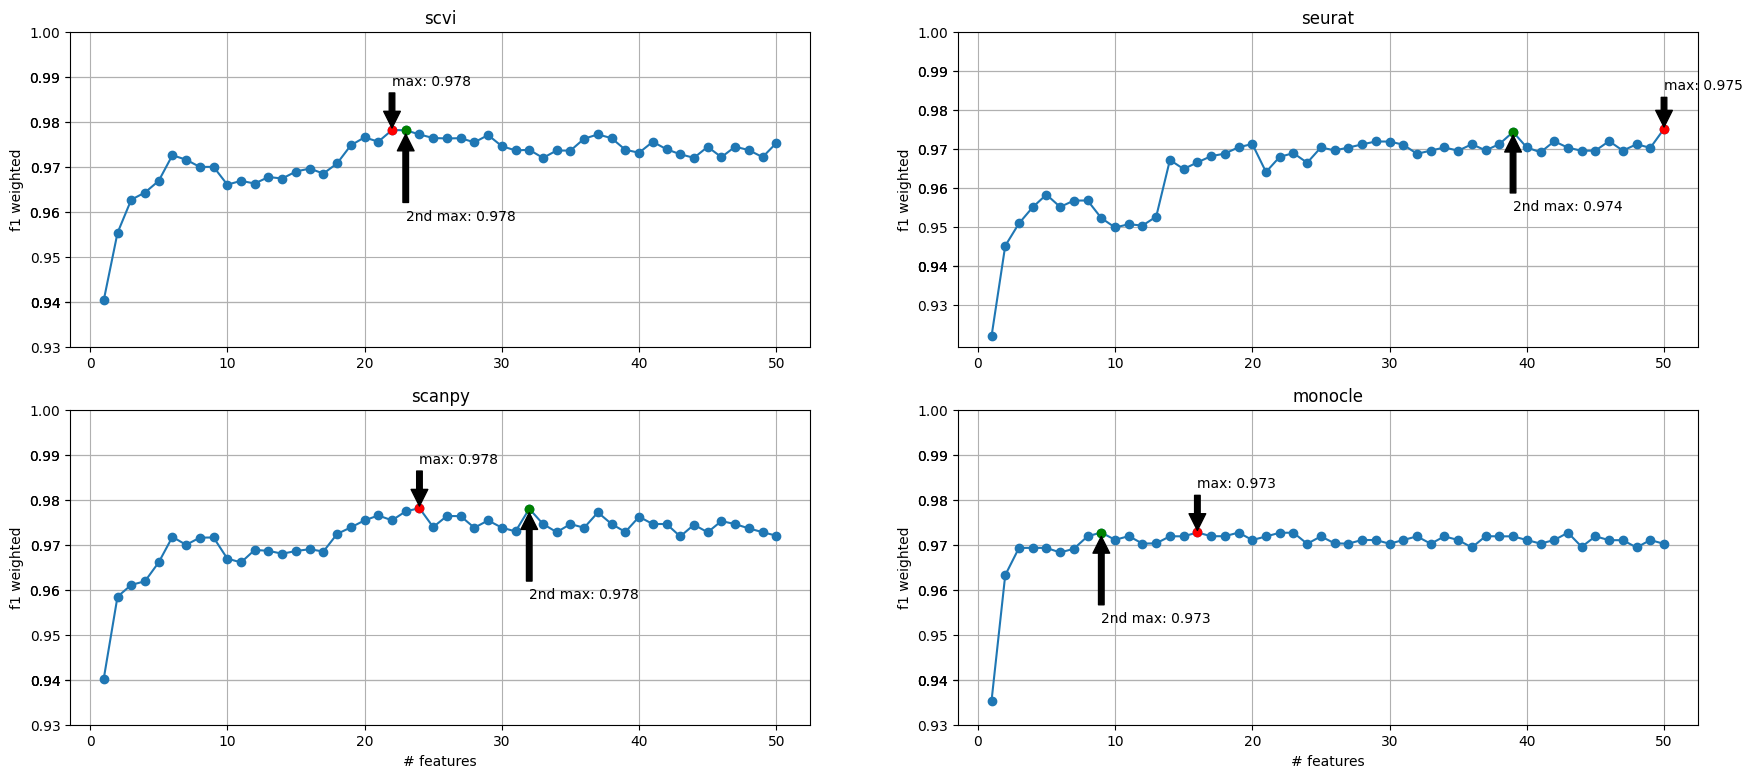

In [86]:
fig, ax = plt.subplots(2, 2, figsize=(21, 9))
for i, tool in enumerate(tools):
    max_i = np.argmax(scores[tool]['TotalMean'])
    second_max = np.argsort(scores[tool]['TotalMean'])[-2]
    ax[i//2, i%2].plot([i for i in range(step, n_markers+step, step)], scores[tool]['TotalMean'], marker='o')
    # print max max in red
    ax[i//2, i%2].plot([max_i+1], [scores[tool]['TotalMean'][max_i]], marker='o', color='red')
    # print second max in green
    ax[i//2, i%2].plot([second_max+1], [scores[tool]['TotalMean'][second_max]], marker='o', color='green')
    # annotation for max
    ax[i//2, i%2].annotate('max: {}'.format(round(scores[tool]['TotalMean'][max_i], 3)), xy=(max_i+1, scores[tool]['TotalMean'][max_i]), xytext=(max_i+1, scores[tool]['TotalMean'][max_i]+0.01), arrowprops=dict(facecolor='black', shrink=0.05))
    # annotation for second max
    ax[i//2, i%2].annotate('2nd max: {}'.format(round(scores[tool]['TotalMean'][second_max], 3)), xy=(second_max+1, scores[tool]['TotalMean'][second_max]), xytext=(second_max+1, scores[tool]['TotalMean'][second_max]-0.02), arrowprops=dict(facecolor='black', shrink=0.05))
    ax[i//2, i%2].set_ylabel("f1 weighted")
    if (i>1):
        ax[i//2, i%2].set_xlabel("# features")
    ax[i//2, i%2].set_yticks([round(i, 2) for i in np.arange(0.930, 1, 0.005)])
    ax[i//2, i%2].set_title(tool)
    ax[i//2, i%2].grid()

In [ ]:
# -------- train on all features and on markers --------

X_all = adata[mask, :].X.toarray()
report_all, feature_importance = apply_classifier(X_all, y)
report_markers, _ = apply_classifier(adata[mask, markers].X.toarray(), y)

pd.DataFrame(report_all).transpose().to_csv(out_path+"clf_report_all.csv")
pd.DataFrame(report_markers).transpose().to_csv(out_path+"clf_report_markers.csv")

sorted_idx = (-feature_importance).argsort()
rf_features_sorted = adata.var_names[sorted_idx]
importaces_sorted = feature_importance[sorted_idx]
pd.DataFrame(
    {'genes' : rf_features_sorted, 'importaces' : importaces_sorted}
    ).to_csv(out_path+"importances.csv")

In [ ]:
# -------- select n_markers*n_clusters features with RFE and RF --------

selector = RFE(RandomForestClassifier(), n_features_to_select=n_markers*n_clusters, step=0.5)
selector.fit(X_all, y)
sorted_idx = (selector.ranking_).argsort()
rfe_features_sorted = adata.var_names[sorted_idx]
pd.DataFrame(
    {'genes' : rfe_features_sorted}
    ).to_csv(out_path+"rfe_ranking.csv")

# automatically choose the number of features
# rfe = RFECV(estimator=RandomForestClassifier())
# rfe.fit(X_all, y)
# rfe.show()

# TODO:
# - valutare intersezione
# - valutare bontà del ranking allenando con markers più in basso nella classifica?

# important_features = features_sorted[0:120]
# important_features = [f for f, i in zip(features_sorted, importaces_sorted) if i >= importaces_sorted[119]]
# intersection = set(markers).intersection(set(important_features))

#        rank di randomforest                  rank del tool
# gene1         100 *                         * 1 - (0-20)
# gene2         1 *                            
# gene3         1 *                            
# gene4         0 *                            